# BiGAN with MNIST (or Fashion MNIST)

* `Adversarial Feature Learning`, [arXiv:1605.09782](https://arxiv.org/abs/1605.09782)
  * Jeff Donahue, Philipp Krähenbühl, and Trevor Darrell
  
* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)
* Use `transposed_conv2d` and `conv2d` for Generator and Discriminator, respectively.
  * I do not use `dense` layer for model architecture consistency. (So my architecture is different from original dcgan structure)
* based on DCGAN model

## 1. Import modules

In [2]:
import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 2. Setting hyperparameters

In [4]:
# Training Flags (hyperparameter configuration)
model_name = 'bigan'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'mnist'
assert dataset_name in ['mnist', 'fashion_mnist']

max_epochs = 50
save_model_epochs = 10
print_steps = 100
save_images_epochs = 1
batch_size = 256
learning_rate_D = 1e-4
learning_rate_G = 1e-4
k = 1 # the number of step of learning D before learning G (Not used in this code)
num_examples_to_generate = 25
noise_dim = 100
MNIST_SIZE = 28

## 3. Load the MNIST dataset

In [5]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), (test_images, test_labels) = \
      tf.keras.datasets.mnist.load_data()
else:
  (train_images, train_labels), (test_images, test_labels) = \
      tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(-1, MNIST_SIZE, MNIST_SIZE, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

test_images = test_images.reshape(-1, MNIST_SIZE, MNIST_SIZE, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

## 4. Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [6]:
#tf.random.set_seed(219)

# for train
N = len(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset = test_dataset.shuffle(buffer_size=N)
test_dataset = test_dataset.batch(batch_size=num_examples_to_generate, drop_remainder=True)
print(test_dataset)

2021-12-23 21:10:33.933060: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<BatchDataset shapes: (256, 28, 28, 1), types: tf.float32>
<BatchDataset shapes: (25, 28, 28, 1), types: tf.float32>


2021-12-23 21:10:34.344435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22318 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


## 5. Create the generator and discriminator models

In [7]:
class ConvTranspose(tf.keras.Model):
  def __init__(self, filters, kernel_size, padding='same',
               apply_batchnorm=True, activation='relu'):
    super(ConvTranspose, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    assert activation in ['relu', 'sigmoid', 'tanh']
    self.activation = activation
    self.up_conv = layers.Conv2DTranspose(filters=filters,
                                          kernel_size=(kernel_size, kernel_size),
                                          strides=2,
                                          padding=padding,
                                          kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                          use_bias=not self.apply_batchnorm)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization()

  def call(self, x, training=True):
    # conv transpose
    x = self.up_conv(x)
    
    # batchnorm
    if self.apply_batchnorm:
      x = self.batchnorm(x, training=training)
      
    # activation
    if self.activation == 'relu':
      x = tf.nn.relu(x)
    elif self.activation == 'sigmoid':
      x = tf.nn.sigmoid(x)
    else:
      x = tf.nn.tanh(x)
    
    return x

In [8]:
class Generator(tf.keras.Model):
  """Build a generator that maps latent space to real space.
    G(z): z -> x
  """
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = ConvTranspose(256, 3, padding='valid')
    self.conv2 = ConvTranspose(128, 3, padding='valid')
    self.conv3 = ConvTranspose(64, 4)
    self.conv4 = ConvTranspose(1, 4, apply_batchnorm=False, activation='tanh')

  def call(self, inputs, training=True):
    """Run the model."""
    # inputs: [1, 1, 100]
    conv1 = self.conv1(inputs, training=training)           # conv1: [3, 3, 256]
    conv2 = self.conv2(conv1, training=training)            # conv2: [7, 7, 128]
    conv3 = self.conv3(conv2, training=training)            # conv3: [14, 14, 64]
    generated_images = self.conv4(conv3, training=training) # generated_images: [28, 28, 1]
    
    return generated_images

In [9]:
class Conv(tf.keras.Model):
  def __init__(self, filters, kernel_size, strides, padding='same',
               apply_batchnorm=True, activation='relu'):
    super(Conv, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    assert activation in ['relu', 'leaky_relu', 'none']
    self.activation = activation
        
    self.conv = layers.Conv2D(filters=filters,
                              kernel_size=(kernel_size, kernel_size),
                              strides=strides,
                              padding=padding,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02),
                              use_bias=not self.apply_batchnorm)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization()
  
  def call(self, x, training=True):
    # convolution
    x = self.conv(x)
    
    # batchnorm
    if self.apply_batchnorm:
      x = self.batchnorm(x, training=training)
    
    # activation
    if self.activation == 'relu':
      x = tf.nn.relu(x)
    elif self.activation == 'leaky_relu':
      x = tf.nn.leaky_relu(x)
    else:
      pass
    
    return x

In [10]:
class Encoder(tf.keras.Model):
  """Build a encoder that maps real space to latent space.
    E(x): x -> z
  """
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = Conv(64, 4, 2, apply_batchnorm=False, activation='leaky_relu')
    self.conv2 = Conv(128, 4, 2, activation='leaky_relu')
    self.conv3 = Conv(256, 3, 2, padding='valid', activation='leaky_relu')
    self.conv4 = Conv(100, 3, 1, padding='valid', apply_batchnorm=False, activation='none')
    
  def call(self, inputs, training=True):
    """Run the model."""
    # inputs: [28, 28, 1]
    conv1 = self.conv1(inputs, training=training)   # conv1: [14, 14, 64]
    conv2 = self.conv2(conv1, training=training)    # conv2: [7, 7, 128]
    conv3 = self.conv3(conv2, training=training)    # conv3: [3, 3, 256]
    z_vector = self.conv4(conv3, training=training) # z_vector: [1, 1, 100]
    
    return z_vector

In [11]:
class Discriminator(tf.keras.Model):
  """Build a discriminator that discriminate tuple (x, z) whether real or fake.
    D(x, z): (x, z) -> [0, 1]
  """
  def __init__(self):
    super(Discriminator, self).__init__()
    self.fc = layers.Dense(MNIST_SIZE * MNIST_SIZE * 2, activation=tf.nn.leaky_relu)
    self.conv1 = Conv(64, 4, 2, apply_batchnorm=False, activation='leaky_relu')
    self.conv2 = Conv(128, 4, 2, activation='leaky_relu')
    self.conv3 = Conv(256, 3, 2, padding='valid', activation='leaky_relu')
    self.conv4 = Conv(1, 3, 1, padding='valid', apply_batchnorm=False, activation='none')

  def call(self, image_inputs, latent_codes, training=True):
    """Run the model."""
    # latent_code: [1, 1, 100]
    latent_codes = tf.squeeze(latent_codes, axis=[1, 2])
    fc = self.fc(latent_codes)
    fc = tf.reshape(fc, [-1, MNIST_SIZE, MNIST_SIZE, 2])
    
    # concatnate image_inputs + latent code
    # image_inputs: [28, 28, 1] + fc: [28, 28, 2]
    inputs = tf.concat([image_inputs, fc], axis=3)        # inputs: [28, 28, 3]
    conv1 = self.conv1(inputs)                            # conv1: [14, 14, 64]
    conv2 = self.conv2(conv1)                             # conv2: [7, 7, 128]
    conv3 = self.conv3(conv2)                             # conv3: [3, 3, 256]
    conv4 = self.conv4(conv3)                             # conv4: [1, 1, 1]
    discriminator_logits = tf.squeeze(conv4, axis=[1, 2]) # discriminator_logits: [1,]
    
    return discriminator_logits

In [12]:
generator = Generator()
encoder = Encoder()
discriminator = Discriminator()

### Plot generated image via generator network

2021-12-23 21:11:04.283262: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-12-23 21:11:04.992202: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


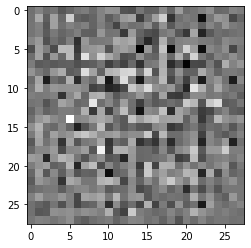

In [13]:
noise = tf.random.normal([1, 1, 1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Test encoder network

In [14]:
z_hat = encoder(generated_image)
print(z_hat)

tf.Tensor(
[[[[ 0.02259328  0.00445552  0.0320874  -0.00533755  0.04085628
     0.03861467 -0.01301613 -0.02870813  0.01343789 -0.0334442
    -0.00208074 -0.01275927  0.02887837 -0.00086095 -0.00768849
     0.02493885 -0.00917022 -0.00015116 -0.04516261  0.04060756
    -0.00771213 -0.01377336  0.04142745  0.04251891 -0.00537447
    -0.01195845  0.02881513  0.00959712 -0.03715638 -0.01427208
     0.03041586 -0.03827891 -0.03159384 -0.01103068 -0.00439942
     0.00239867 -0.0232558   0.0162882   0.03189998 -0.0671836
     0.04010114 -0.0368658   0.00254505  0.04502714 -0.01007249
     0.03219422 -0.01001368  0.02932041  0.03156786  0.02414179
    -0.01606447  0.02300004 -0.03561935 -0.03679963  0.00377759
     0.04044802 -0.02085817  0.00872027  0.00286835 -0.0359893
     0.01018863  0.0030336  -0.04936004 -0.02015754 -0.05504169
    -0.01902892 -0.00537221 -0.03390665  0.00565179 -0.0099154
     0.03316126 -0.04861396 -0.03950123  0.02592454 -0.00070474
     0.00307522 -0.01482304 -0.00

### Test discriminator network

* **CAUTION**: the outputs of discriminator is **logits** (unnormalized probability) NOT probabilites

In [15]:
decision = discriminator(generated_image, noise)
print(decision)

tf.Tensor([[0.06756537]], shape=(1, 1), dtype=float32)


## 6. Define the loss functions and the optimizer

In [16]:
# use logits for consistency with previous code I made
# `tf.losses` and `tf.keras.losses` are the same API (alias)
bce = tf.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def GANLoss(logits, is_real=True):
  """Computes standard GAN loss between `logits` and `labels`.

  Args:
    logits (`2-rank Tensor`): logits.
    is_real (`bool`): True means `1` labeling, False means `0` labeling.

  Returns:
    loss (`0-rank Tensor`): the standard GAN loss value. (binary_cross_entropy)
  """
  if is_real:
    labels = tf.ones_like(logits)
  else:
    labels = tf.zeros_like(logits)

  return bce(labels, logits)

In [18]:
def discriminator_loss(real_logits, fake_logits):
  # losses of real with label "1"
  real_loss = GANLoss(logits=real_logits, is_real=True)
  # losses of fake with label "0"
  fake_loss = GANLoss(logits=fake_logits, is_real=False)
  
  return real_loss + fake_loss

In [19]:
def generator_loss(real_logits, fake_logits):
  # losses of fake with label "0" that used to fool the discriminator
  real_loss = GANLoss(logits=real_logits, is_real=False)
  # losses of Generator with label "1" that used to fool the discriminator
  fake_loss = GANLoss(logits=fake_logits, is_real=True)
  
  return real_loss + fake_loss

In [21]:
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate_D)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate_G, beta_1=0.5)

### 7. Training

In [22]:
# keeping the random image constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
# To visualize progress in the animated GIF
for inputs in test_dataset.take(1):
  constant_test_input = inputs

### Define training one step function

In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  # generating noise from a uniform distribution
  noise = tf.random.uniform([batch_size, 1, 1, noise_dim], minval=-1.0, maxval=1.0)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # generating images from generator() via random noise vector z
    generated_images = generator(noise, training=True)
    # inference latent codes from encoder via real images
    inference_codes = encoder(images, training=True)

    # discriminating tuple (real images, inference_codes) by discriminator()
    real_logits = discriminator(images, inference_codes, training=True)
    # discriminating tuple (generated_images, random_z) by discriminator()
    fake_logits = discriminator(generated_images, noise, training=True)

    gen_loss = generator_loss(real_logits, fake_logits)
    disc_loss = discriminator_loss(real_logits, fake_logits)
    
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables + encoder.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                          generator.trainable_variables + encoder.trainable_variables))

  return gen_loss, disc_loss

### Train full steps

Epochs: 11.11 global_step: 2600 loss_D: 0.77 loss_G: 2.64 (21886.75 examples/sec; 0.012 sec/batch)


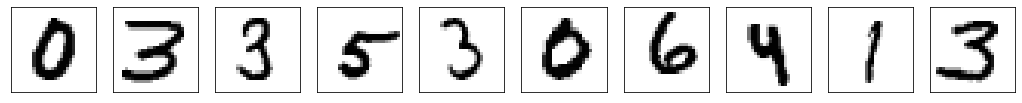

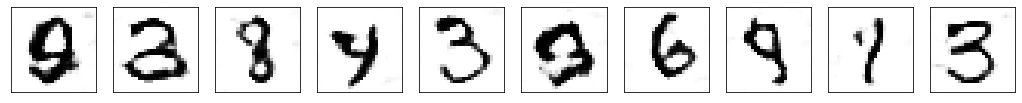

KeyboardInterrupt: 

In [25]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)

for epoch in range(max_epochs):
  
  for step, images in enumerate(train_dataset):
    start_time = time.time()
    
    gen_loss, disc_loss = train_step(images)
    global_step.assign_add(1)

    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} loss_D: {:.3g} loss_G: {:.3g} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), disc_loss, gen_loss, examples_per_sec, duration))
      for images in test_dataset.take(1):
        sample_inference_codes = encoder(images, training=False)
        reconstruction_images = generator(sample_inference_codes, training=False)
        plt.figure(figsize=[18, 3])
        for j in range(10):
            plt.subplot(1, 10, j+1)
            plt.imshow(images[j, :, :, 0], cmap='binary')
            plt.xticks([])
            plt.yticks([])
        plt.show()
        plt.figure(figsize=[18, 3])
        for j in range(10):
            plt.subplot(1, 10, j+1)
            plt.imshow(reconstruction_images[j, :, :, 0], cmap='binary')
            plt.xticks([])
            plt.yticks([])
        plt.show()
    
print('Training Done.')